<a href="https://colab.research.google.com/github/SaAPro/pneumonia-diagnosis-model-tf-keras/blob/master/pneumonia-diagnosis-model-tf-keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pneumonia Diagnosis Model using TensorFlow and Keras
In this notebook, we will see how to detect pneumonia form chest x-ray images using deep learning. We will use transfer learning from a Keras pre-trained image classifier - the inception v3, and retrain it on our dataset.

*For better performances, select a GPU backend for this notebook.*

To have an overview on how to use tf.data: https://www.tensorflow.org/tutorials/load_data/images

For a practical tutorial on transfer learning with Keras: https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04_Keras_Flowers_transfer_learning_solution.ipynb#scrollTo=MPkvHdAYNt9J

In [1]:
#Drive mounting with google.colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Import libraries

In [2]:
import sys
import os
import math
import random

import numpy as np
#import pandas as pd

import tensorflow as tf
tf.enable_eager_execution()
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

#import seaborn as sns


Tensorflow version 1.14.0


Using TensorFlow backend.


## Download the dataset from Kaggle
Create an account on https://www.kaggle.com in order to download the dataset. Then generate a Kaggle API key directly from your settings account and update the KAGGLE_USERNAME and KAGGLE_KEY with the generated key.

In [3]:
os.environ['KAGGLE_USERNAME'] = "XXXXXX" 
os.environ['KAGGLE_KEY'] = "XXXXXX" 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.13G/1.15G [00:16<00:00, 77.7MB/s]
100% 1.15G/1.15G [00:16<00:00, 72.9MB/s]


##Unzip the dataset with ZipFile

In [0]:
from zipfile import ZipFile

zf = ZipFile('chest-xray-pneumonia.zip', 'r')
zf.extractall()
zf.close()

In [0]:
zf = ZipFile('chest_xray.zip', 'r')
zf.extractall()
zf.close()

## Data preprocessing
The data is in the chest_xray folder and is organized in 3 directories: one for training, an other to validate the training and finally the one to test the trained model. Each one contains two sub directories, one containing the images of normal chest xray and the other one containing the images of chest xray with pneumonia.

In [0]:
training_dir = "/content/chest_xray/train"
validation_dir = "/content/chest_xray/val"
testing_dir = "/content/chest_xray/test"
categories = ['NORMAL','PNEUMONIA']

IMG_SIZE = 299 #check the input size of the model you want to train

In [0]:
import pathlib

#From a directory, retreive all images, put them in a list and shuffle them
#Return the shuffled list of these files
def get_and_shuffle_image_paths(directory):
  data_root = pathlib.Path(directory)
  image_paths = list(data_root.glob('*/[!.]*'))
  image_paths = [str(path) for path in image_paths]
  random.shuffle(image_paths)
  print('%i images loaded from %s' % (len(image_paths), directory))
  
  return image_paths

#Retreive the list of labels from a directory and return this list
def get_label_list(directory):
  data_root = pathlib.Path(directory)
  label_list = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
  print('label list : ', label_list)
  
  return label_list

#Retreive the images labels from there path and store them in a list and return this list
def get_labels(dic, image_paths):
  image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in image_paths]
  
  return image_labels

In [8]:
#Build the images lists for training, validation and testing
training_image_paths = get_and_shuffle_image_paths(training_dir)
validation_image_paths = get_and_shuffle_image_paths(validation_dir)
testing_image_paths = get_and_shuffle_image_paths(testing_dir)

#Store the size of the datasets to configure the batches
training_image_count = len(training_image_paths)
validation_image_count = len(validation_image_paths)
testing_image_count = len(testing_image_paths)

5216 images loaded from /content/chest_xray/train
16 images loaded from /content/chest_xray/val
624 images loaded from /content/chest_xray/test


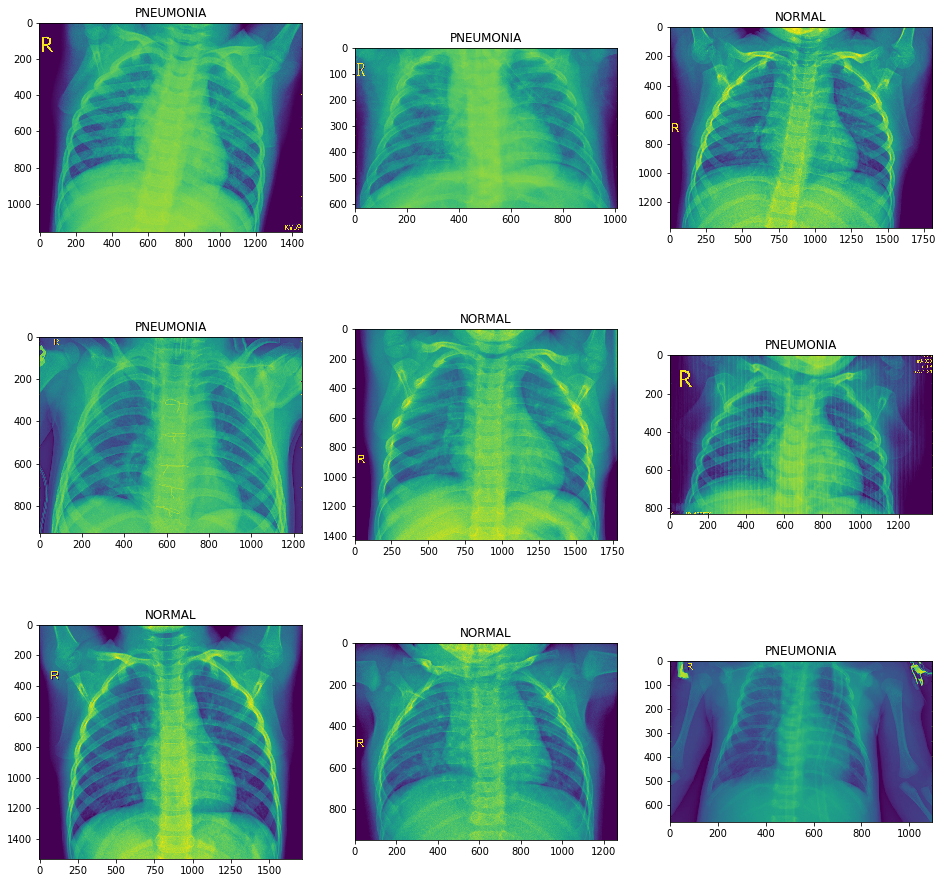

In [9]:
#Display random images from the training data
fig, axs = plt.subplots(3,3,figsize=(16,16))
for n,ax in enumerate(axs.flat):
  image_path = random.choice(training_image_paths)
  img = mpimg.imread(image_path)
  ax.imshow(img)
  title = '{}'.format(pathlib.Path(image_path).parent.name)
  ax.set_title(title)

In [10]:
#Retreive the label list
label_list = get_label_list(training_dir)

#Build a dictionnary to bind each label with an index
label_to_index = dict((name, index) for index,name in enumerate(label_list))
print('label to index dictionnary : ', label_to_index)

#Retreive the images labels for each dataset
training_image_labels = get_labels(label_to_index, training_image_paths)
validation_image_labels = get_labels(label_to_index, validation_image_paths)
testing_image_labels = get_labels(label_to_index, testing_image_paths)

label list :  ['NORMAL', 'PNEUMONIA']
label to index dictionnary :  {'NORMAL': 0, 'PNEUMONIA': 1}


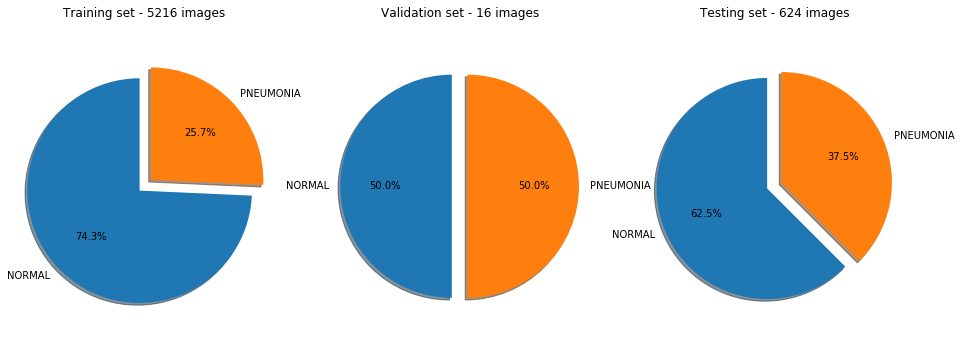

In [11]:
from collections import Counter

#Print useful information on the datasets
titles = ['Training set - ' + str(training_image_count) + ' images',
          'Validation set - ' + str(validation_image_count) + ' images',
          'Testing set - ' + str(testing_image_count) + ' images',]
counters = [Counter(training_image_labels), Counter(validation_image_labels), Counter(testing_image_labels)]

fig, axs = plt.subplots(1,3,figsize=(16,6))
for n,ax in enumerate(axs.flat):
  ax.set_title(titles[n])
  ax.pie(counters[n].values(), explode=(.07,.07), labels = label_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
  ax.axis('equal')


##Load and format images

In [0]:
#Decode and resize the given image
def preprocess_image(image):
  #Inception v3 expects jpeg images
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.uint8)
  
  #Inception v3 expects input from range [0,255]
  #image /= 255.0  # normalize to [0,1] range
  #image = tf.image.encode_jpeg(image)

  return image

#Load and preprocess the image from its path
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  
  return preprocess_image(image)

##Build tf.data.Datasets with our data
The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

Slicing the array of strings results in a dataset of strings.

In [0]:
#Build the path datasets
training_path_ds = tf.data.Dataset.from_tensor_slices(training_image_paths)
validation_path_ds = tf.data.Dataset.from_tensor_slices(validation_image_paths)
testing_path_ds = tf.data.Dataset.from_tensor_slices(testing_image_paths)


We create a new dataset that loads and formats images on the fly by mapping preprocess_image over the dataset of paths.

In [0]:
#Build the images datasets
training_image_ds = training_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
validation_image_ds = validation_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
testing_image_ds = testing_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

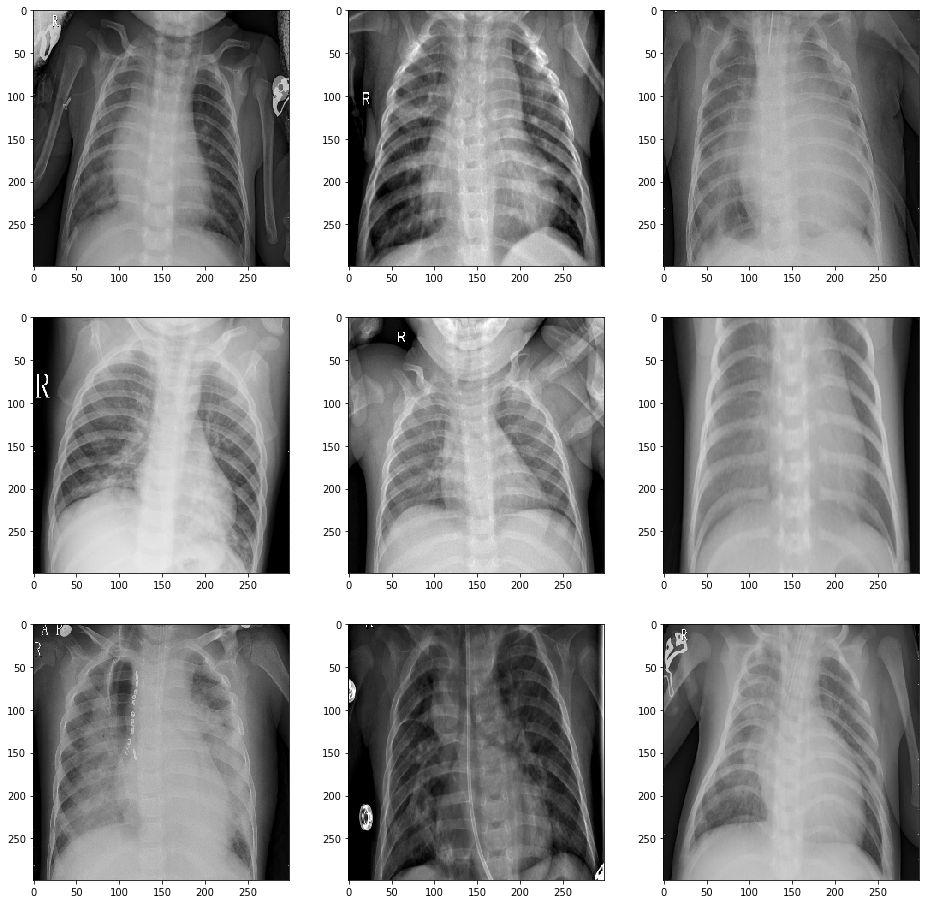

In [15]:
#Plot 9 images of the training dataset
plt.subplots(3,3,figsize=(16,16))
for n,image in enumerate(training_image_ds.take(9)):
  plt.subplot(3,3,n+1)
  plt.imshow(np.uint8(image))

In [0]:
#Buil the labels datasets
training_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(training_image_labels, tf.int64))
validation_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(validation_image_labels, tf.int64))
testing_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(testing_image_labels, tf.int64))

In [17]:
#Display some labels of the training dataset
for label in training_label_ds.take(10):
  print('{} {}'.format(label, label_list[label.numpy()]))

1 PNEUMONIA
1 PNEUMONIA
1 PNEUMONIA
1 PNEUMONIA
0 NORMAL
1 PNEUMONIA
1 PNEUMONIA
1 PNEUMONIA
1 PNEUMONIA
1 PNEUMONIA


Since the datasets are in the same order we can just zip them together to get a dataset of (image, label) pairs

In [18]:
training_image_label_ds = tf.data.Dataset.zip((training_image_ds, training_label_ds))
validation_image_label_ds = tf.data.Dataset.zip((validation_image_ds, validation_label_ds))
testing_image_label_ds = tf.data.Dataset.zip((testing_image_ds, testing_label_ds))

print(training_image_label_ds)

<DatasetV1Adapter shapes: ((299, 299, 3), ()), types: (tf.uint8, tf.int64)>


##Prepare the datasets
A good dataset is a well **shuffled** and **batched** dataset. This is easily obtained with tf.data api.

In [0]:
def build_batched_dataset(image_label_ds, image_count, BATCH_SIZE = 64):
  # Setting a shuffle buffer size as large as the dataset ensures that the data is
  # completely shuffled.
  ds = image_label_ds.cache()
  ds = ds.shuffle(buffer_size=image_count)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  # `prefetch` lets the dataset fetch batches, in the background while the model is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  
  return ds

In [0]:
BATCH_SIZE = 128 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU

training_ds = build_batched_dataset(training_image_label_ds, training_image_count, BATCH_SIZE)
validation_ds = build_batched_dataset(validation_image_label_ds, validation_image_count, BATCH_SIZE)
testing_ds = build_batched_dataset(testing_image_label_ds, testing_image_count, BATCH_SIZE)


##Machine learning
The pretrained model **inception v3** available in *tf.keras.applications* will be retrained on our dataset. **Transfer learning** allow us to greatly speed up the training process.

For information concerning the **inception v3** model follow this link: https://keras.io/applications/#inceptionv3

In [0]:
#Configuration
EPOCHS = 3
STEPS_PER_EPOCHS = steps_per_epoch=tf.ceil(len(training_image_paths)/BATCH_SIZE).numpy()
VALIDATION_STEPS = 1

In [22]:
#Model definition
pretrained_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3))
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(label_list), activation='softmax')
])

96116736/96112376 [==============================] - 3s 0us/step


In [23]:
#Model compiling and summary
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1000)              23851784  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2002      
Total params: 23,853,786
Trainable params: 2,002
Non-trainable params: 23,851,784
_________________________________________________________________


In [24]:
#Model training with validation dataset
history = model.fit(training_ds, steps_per_epoch=STEPS_PER_EPOCHS, epochs=EPOCHS,
                    validation_data=validation_ds, validation_steps=VALIDATION_STEPS)

Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 1480s 36s/step - loss: 0.6757 - acc: 0.7273 - val_loss: 0.6954 - val_acc: 0.5000
Epoch 2/3
41/41 [==============================] - 1451s 35s/step - loss: 0.6446 - acc: 0.7426 - val_loss: 0.6999 - val_acc: 0.5000
Epoch 3/3
41/41 [==============================] - 1442s 35s/step - loss: 0.6200 - acc: 0.7435 - val_loss: 0.7043 - val_acc: 0.5000


##Results
###Model evaluation

In [25]:
# Evaluate the model on the testing dataset using `evaluate`
results = model.evaluate(testing_ds, steps=1)
print('test loss, test acc:', results)

1/1 [==============================] - 33s 33s/step - loss: 0.6687 - acc: 0.6016
test loss, test acc: [0.6687215566635132, 0.6015625]


###Displaying some results

In [0]:
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

In [0]:
#Make prediction on several images of the testing dataset
images, labels = dataset_to_numpy_util(testing_image_label_ds, 84)

predictions = model.predict(images, steps=1)

prediction_label_list = np.array(label_list)[np.argmax(predictions, axis=-1)].tolist()
expected_label_list = np.array(label_list)[labels]

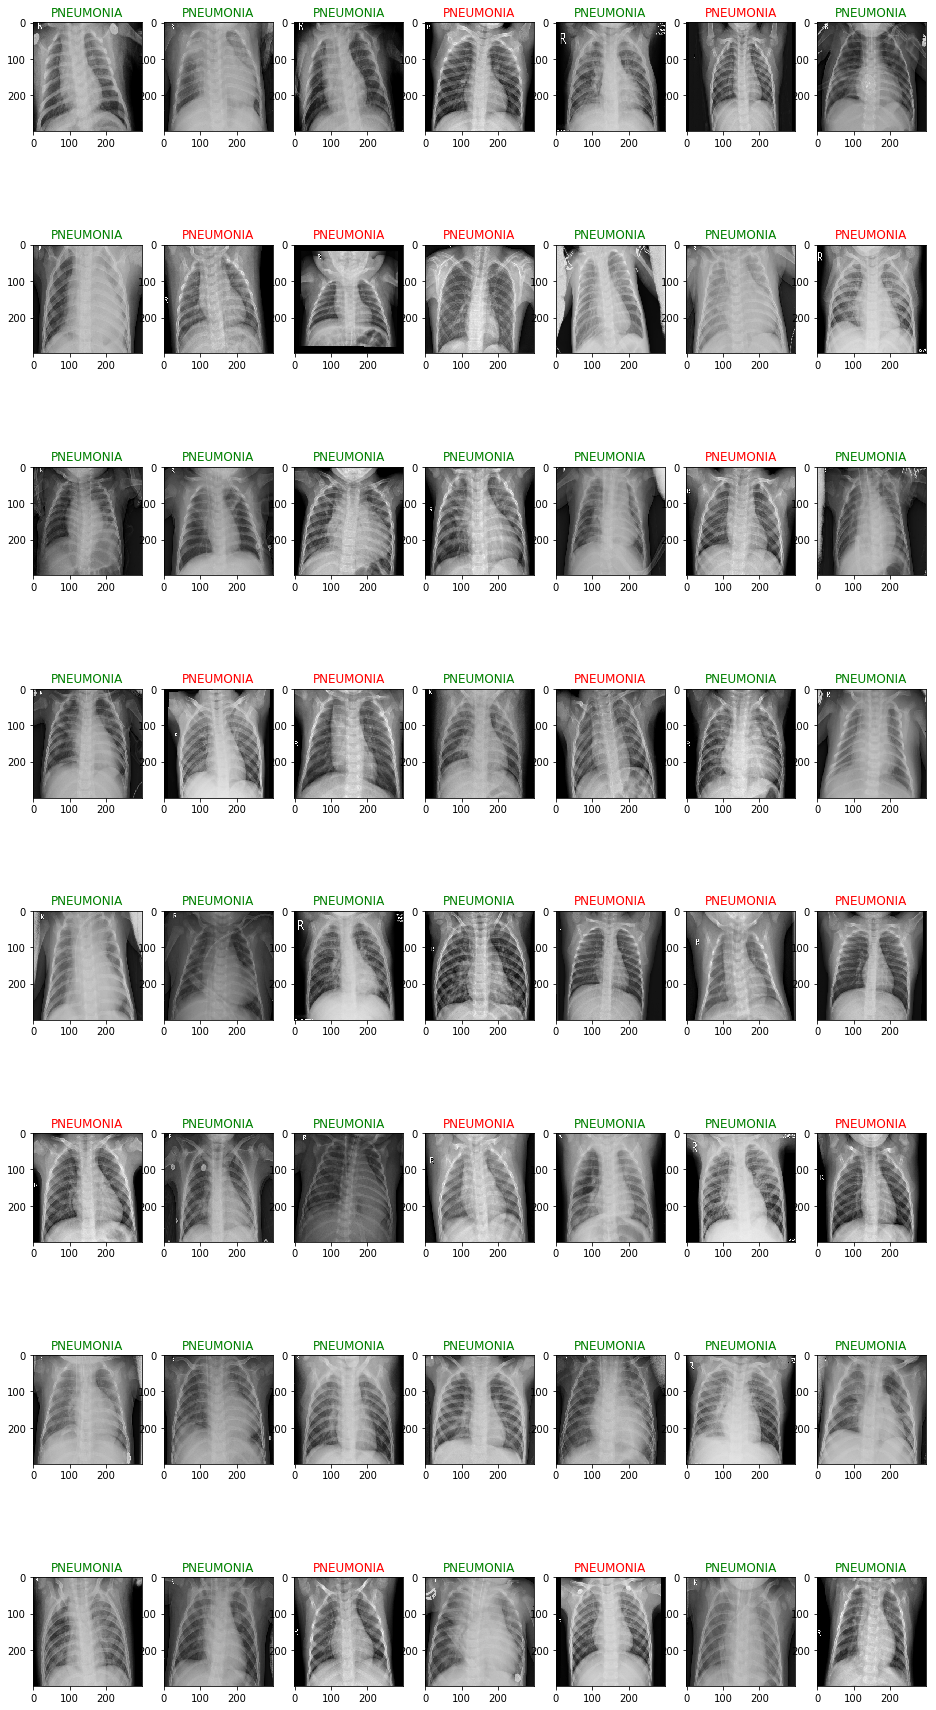

In [28]:
#Display results from the prediciton
fig, axs = plt.subplots(8,7,figsize=(16,32))
for n,ax in enumerate(axs.flat):
  ax.imshow(np.uint8(images[n]))
  prediction = prediction_label_list[n]
  expected = expected_label_list[n]
  title = '{}'.format(prediction)
  if prediction != expected:
    ax.set_title(title, color='r')
  else:
    ax.set_title(title, color='g')